This notebook provides some example cases for using EIF. Three cases of singel blob, multiple blobs, and sinusoidal data that are presented in the paper are used here for this demo. In each case we compare the standard Isolation Forest with the Extended Isolation Forest using the eif package. The eif package can easily be installed using pip as follows:

pip install eif

Various plots such as scatter plots, score distributions, score maps, and tree and forest visualizations are presented. This notebook is meant to demonstrate how to use the basic functionality of eif. For the details of how the algorithm works, see the paper(s) referenced in the repository. 

# Imports

While the core package only need numpy, we make use of other packages in creating our test functions below, mostly for visualization or data generation. They are no however, necessary for the algorithm to run. Feel free to use any other package you like. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

# Utility Functions

These utility functions are used in creating the radial plots below. We use these two functions to find the depth (not anomaly score) a given data point reaches in an Isolation Forest tree. 

In [2]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)
        
def getVals(forest,x, sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for t in forest.Trees:
        r.append(getDepth(x,t.root,1))
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

# Single Blob Example

## Generate Data

Produce a single blob of 2-D data normally distributed with mean [0,0] and covariance of identity. We also add some outliers manually to the data for testing. 

In [3]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 500
np.random.seed(1)
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T

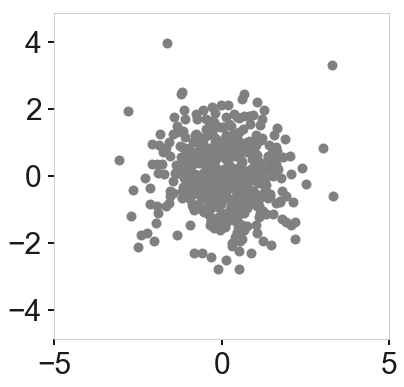

In [4]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', markersize=10, color=[0.5,0.5,0.5])
plt.grid("off")
plt.axis("equal")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=30)
plt.show()

## Train Forests

We train two sets of forests, F0 and F1. F0 is the standard Isolation Forest, which corresponds to extension level 0 in the context of EIF. F1 is the Extended Isolation Forest with extension 1, which in the case of 2_D data (as in here), is the fully extended case. 

In [5]:
F0  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=0) # ExtensionLevel=0 is the same as regular Isolation Forest
F1  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=1)

## Score Data

compute_paths returns that anomaly score. It computes the depth each points reaches in each trained tree, and converts the ensemble aggregate to an anomaly score. 

In [6]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

Here we plot the points and highlight a 10 points with highest and 10 points with lowest anomaly scores. The two plots provide a comparison between the two algorithms.

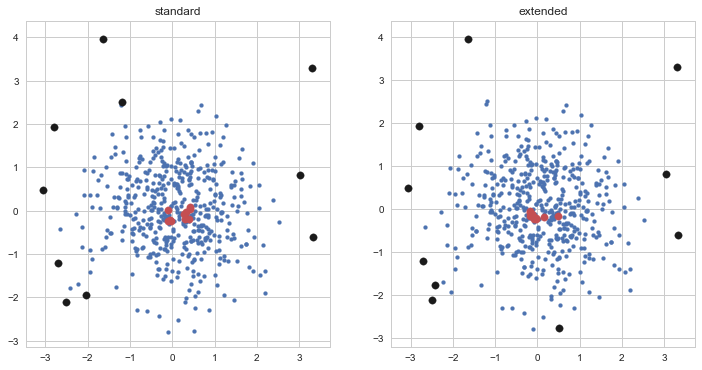

In [7]:
ss0=np.argsort(S0)
ss1=np.argsort(S1)

f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='k')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

The distribution of anomaly scores are shown. By definition, anomalies are those that occur less frequently. So it makes sense that the number of points with higher anomaly scores reduces as the score increases. 

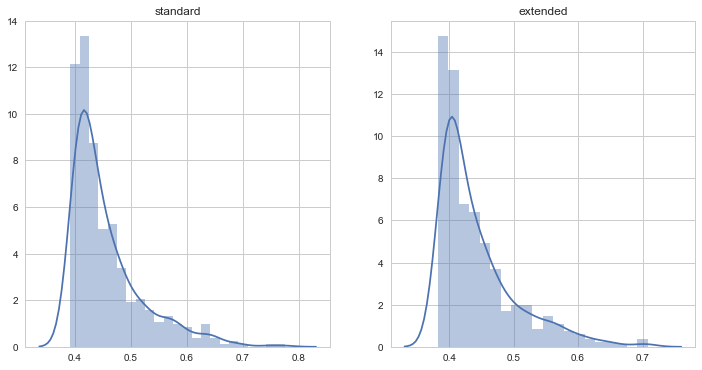

In [8]:
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sb.distplot(S0, kde=True, color="b")
plt.title('standard')

plt.subplot(1,2,2)
sb.distplot(S1, kde=True, color="b")
plt.title('extended')
plt.show()

## Score Maps

We create a meshgrid on a square domain. Each point on the grid is then scored using our trained forests. The resulting score map is visualized using contour plots. 

In [9]:
xx, yy = np.meshgrid(np.linspace(-5., 5., 30), np.linspace(-5., 5, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

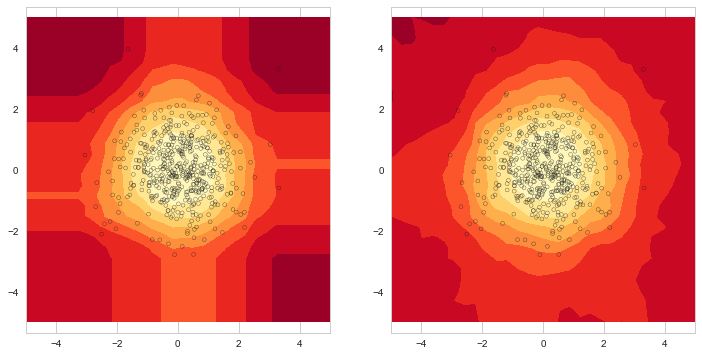

In [10]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


plt.show()

## Forest visualization

For each case, we visualize the forest by passing a single anomalous and a single nominal point through the forest. Each radial line in the plots below corresponds to a tree. The Gray circle is the depth limit each tree can reach. Blue lines show the depth the nominal point reached on each tree, while the red lines show the depth each anomalous point reached for each tree. 
This visualization provides a quick view of how on average anomalous points reach much smaller depths than the nominal points. 

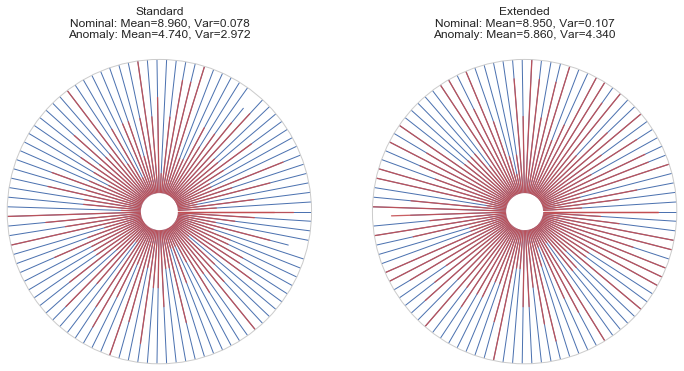

In [11]:
Sorted=False
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection='polar')
rn, thetan = getVals(F0,np.array([0,0]),sorted=Sorted)
for j in range(len(rn)):
    ax1.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F0,np.array([3.3,3.3]),sorted=Sorted)
for j in range(len(ra)):
    ax1.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)
    
ax1.set_title("Standard\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax1.set_xticklabels([])
ax1.set_xlabel("Anomaly")
ax1.set_ylim(0,F0.limit)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)


ax2 = plt.subplot(122, projection='polar')
rn, thetan = getVals(F1,np.array([0,0]),sorted=Sorted)
for j in range(len(rn)):
    ax2.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F1,np.array([3.3,3.3]),sorted=Sorted)
for j in range(len(ra)):
    ax2.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)

    
ax2.set_title("Extended\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax2.set_xticklabels([])
ax2.set_xlabel("Anomaly")
ax2.set_ylim(0,F0.limit)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)


# Multiple Blobs

## Generate Data

Produce a two blobs of 2-D data normally distributed with means [0,10] and [10,0], and covariance of identity. 

In [12]:
mean1 = [10, 0]
cov1 = [[1, 0], [0, 1]]  

mean2 = [0, 10]
cov2 = [[1, 0], [0, 1]]

Nobjs = 500          # Size of dataset.
np.random.seed(1)    # Add this for repeatablilty of the experiment. 

x1, y1 = np.random.multivariate_normal(mean1, cov1, int(Nobjs/2)).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, int(Nobjs/2)).T

# join the two clusters so as to make one dataset. 
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
X=np.array([x,y]).T

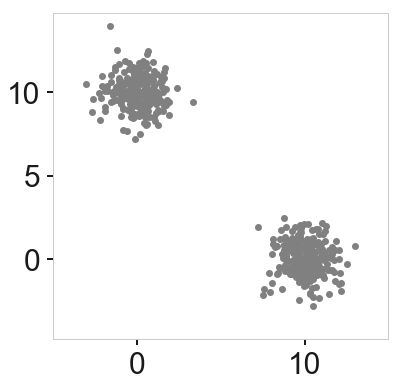

In [13]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', color=[0.5,0.5,0.5])
plt.grid("off")
plt.axis("equal")

plt.xlim([-5,15])
plt.ylim([-5,15])
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=30)

plt.show()

## Train Forests

We train two sets of forests, F0 and F1. F0 is the standard Isolation Forest, which corresponds to extension level 0 in the context of EIF. F1 is the Extended Isolation Forest with extension 1, which in the case of 2_D data (as in here), is the fully extended case. 

In [14]:
F0  = iso.iForest(X,ntrees=100, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X,ntrees=100, sample_size=256, ExtensionLevel=1)

## Score data

compute_paths returns that anomaly score. It computes the depth each points reaches in each trained tree, and converts the ensemble aggregate to an anomaly score. 

In [15]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

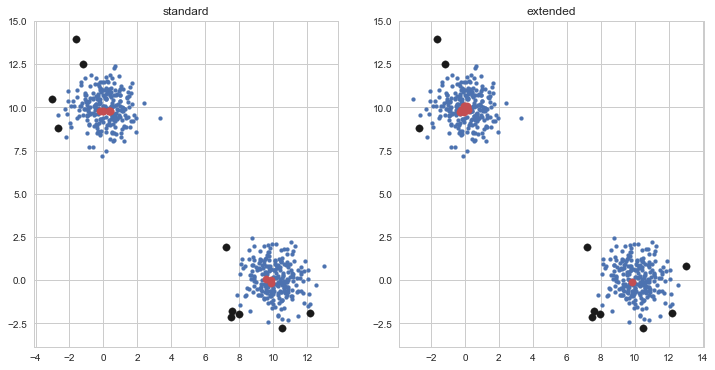

In [16]:
ss0=np.argsort(S0)
ss1=np.argsort(S1)

f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='k')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

The distribution of anomaly scores are shown. By definition, anomalies are those that occur less frequently. So it makes sense that the number of points with higher anomaly scores reduces as the score increases. 

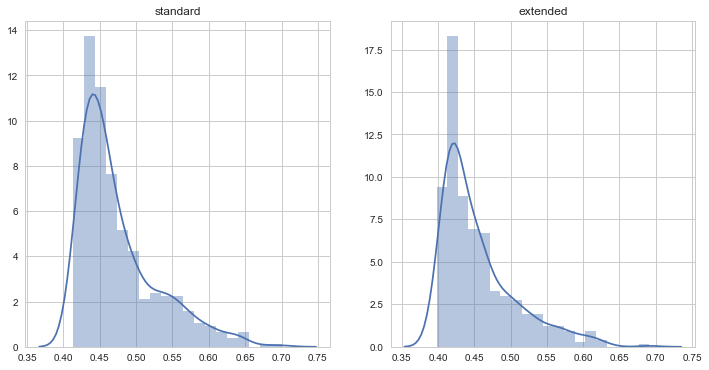

In [17]:
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sb.distplot(S0, kde=True, color="b")
plt.title('standard')

plt.subplot(1,2,2)
sb.distplot(S1, kde=True, color="b")
plt.title('extended')
plt.show()

## Score Maps

We create a meshgrid on a square domain. Each point on the grid is then scored using our trained forests. The resulting score map is visualized using contour plots. 

In [18]:
xx, yy = np.meshgrid(np.linspace(-5, 15, 30), np.linspace(-5, 15, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

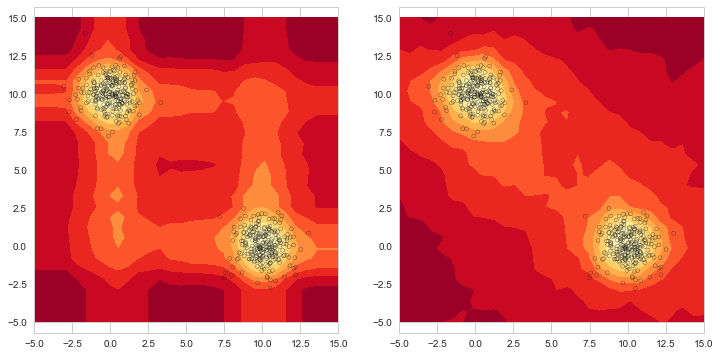

In [19]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


plt.show()

## Forest Visualization

For each case, we visualize the forest by passing a single anomalous and a single nominal point through the forest. Each radial line in the plots below corresponds to a tree. The Gray circle is the depth limit each tree can reach. Blue lines show the depth the nominal point reached on each tree, while the red lines show the depth each anomalous point reached for each tree. 
This visualization provides a quick view of how on average anomalous points reach much smaller depths than the nominal points. 

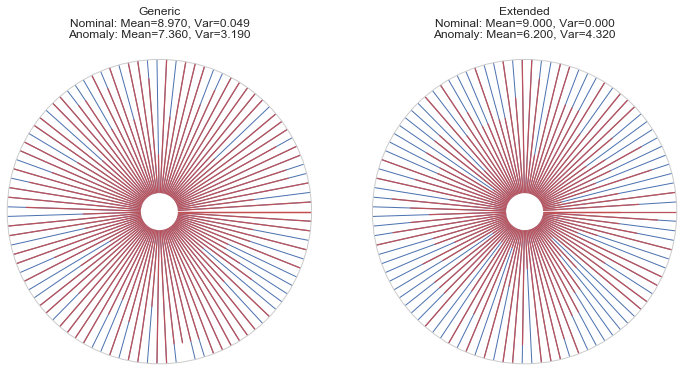

In [20]:
Sorted=False
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection='polar')
rn, thetan = getVals(F0,np.array([10,0]),sorted=Sorted)
for j in range(len(rn)):
    ax1.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F0,np.array([0,0]),sorted=Sorted)
for j in range(len(ra)):
    ax1.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)
    
ax1.set_title("Generic\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax1.set_xticklabels([])
ax1.set_xlabel("Anomaly")
ax1.set_ylim(0,F0.limit)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
#ax1.text(0,F0.limit+0.4,"800 Trees, full depth")

ax2 = plt.subplot(122, projection='polar')
rn, thetan = getVals(F1,np.array([10,0]),sorted=Sorted)
for j in range(len(rn)):
    ax2.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F1,np.array([0,0]),sorted=Sorted)
for j in range(len(ra)):
    ax2.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)

    
ax2.set_title("Extended\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax2.set_xticklabels([])
ax2.set_xlabel("Anomaly")
ax2.set_ylim(0,F0.limit)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
#ax2.text(0,F0.limit+0.4,"800 Trees, full depth")


# Sinusoidal Data

## Generate Data

Produce 2-D dataset with a sinusoidal shape and Gaussian noise added on top.

In [21]:
N = 1000
x = np.random.rand(N)*8*np.pi
y = np.sin(x) + np.random.randn(N)/4.
X=np.array([x,y]).T

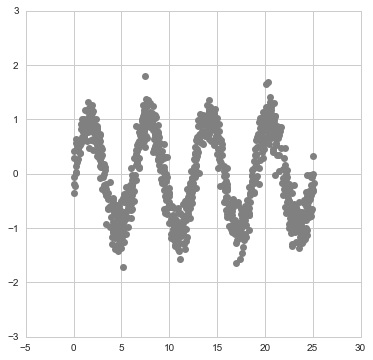

In [22]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', color=[0.5,0.5,0.5])

plt.xlim([-5,30])
plt.ylim([-3.,3.])

plt.show()

## Train Forests

We train two sets of forests, F0 and F1. F0 is the standard Isolation Forest, which corresponds to extension level 0 in the context of EIF. F1 is the Extended Isolation Forest with extension 1, which in the case of 2_D data (as in here), is the fully extended case. 

In [23]:
F0  = iso.iForest(X,ntrees=100, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X,ntrees=100, sample_size=256, ExtensionLevel=1)

## Score Data

compute_paths returns that anomaly score. It computes the depth each points reaches in each trained tree, and converts the ensemble aggregate to an anomaly score. 

In [24]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

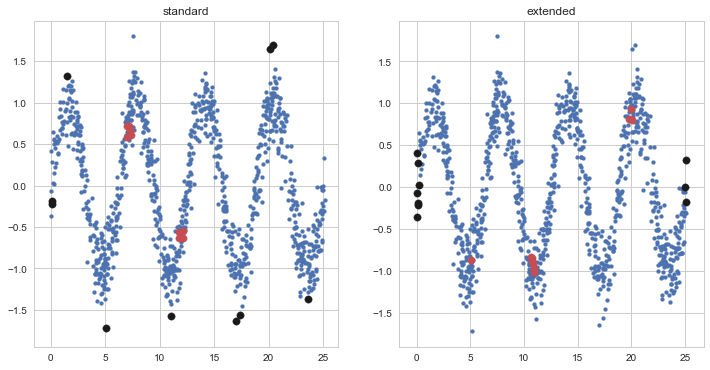

In [25]:
ss0=np.argsort(S0)
ss1=np.argsort(S1)

f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='k')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

The distribution of anomaly scores are shown. By definition, anomalies are those that occur less frequently. So it makes sense that the number of points with higher anomaly scores reduces as the score increases. 

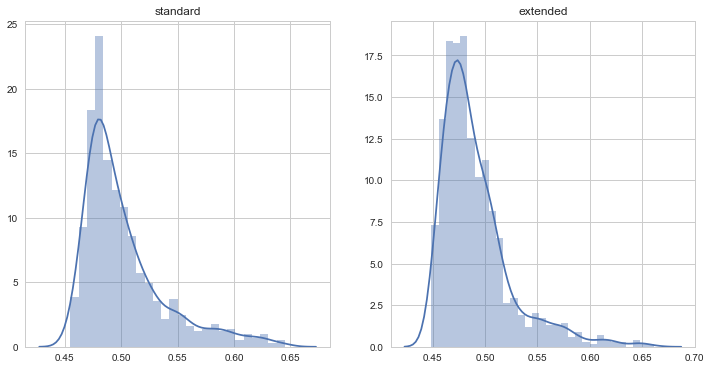

In [26]:
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sb.distplot(S0, kde=True, color="b")
plt.title('standard')

plt.subplot(1,2,2)
sb.distplot(S1, kde=True, color="b")
plt.title('extended')
plt.show()

## Score Maps

We create a meshgrid on a square domain. Each point on the grid is then scored using our trained forests. The resulting score map is visualized using contour plots. 

In [27]:
xx, yy = np.meshgrid(np.linspace(-5, 30, 30), np.linspace(-3, 3, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

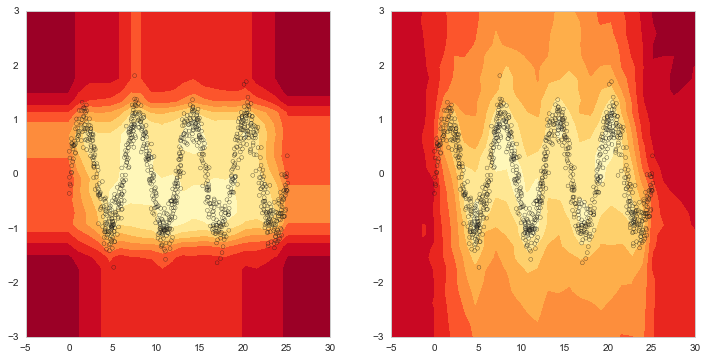

In [28]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


plt.show()

## Forest Visualization

For each case, we visualize the forest by passing a single anomalous and a single nominal point through the forest. Each radial line in the plots below corresponds to a tree. The Gray circle is the depth limit each tree can reach. Blue lines show the depth the nominal point reached on each tree, while the red lines show the depth each anomalous point reached for each tree. 
This visualization provides a quick view of how on average anomalous points reach much smaller depths than the nominal points. 

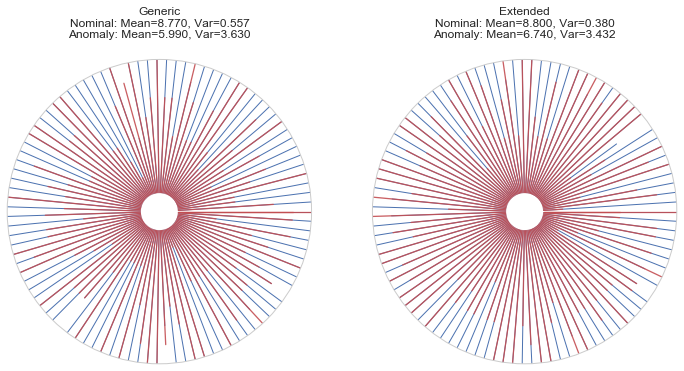

In [29]:
Sorted=False
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection='polar')
rn, thetan = getVals(F0,np.array([10,0]),sorted=Sorted)
for j in range(len(rn)):
    ax1.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F0,np.array([-5,-3]),sorted=Sorted)
for j in range(len(ra)):
    ax1.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)
    
ax1.set_title("Generic\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax1.set_xticklabels([])
ax1.set_xlabel("Anomaly")
ax1.set_ylim(0,F0.limit)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
#ax1.text(0,F0.limit+0.4,"800 Trees, full depth")

ax2 = plt.subplot(122, projection='polar')
rn, thetan = getVals(F1,np.array([10,0]),sorted=Sorted)
for j in range(len(rn)):
    ax2.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F1,np.array([-5,-3]),sorted=Sorted)
for j in range(len(ra)):
    ax2.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)

    
ax2.set_title("Extended\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax2.set_xticklabels([])
ax2.set_xlabel("Anomaly")
ax2.set_ylim(0,F0.limit)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)